In [120]:
import numpy as np 
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import math

# visualizations
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)
%matplotlib inline
from sklearn import metrics, preprocessing

# time series related 
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from timeit import default_timer as timer

# handle warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

KUMPULAN FUNGSI

In [121]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    datatest = adfuller(series, autolag='AIC')
    dataoutput = pd.Series(datatest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in datatest[4].items():
       dataoutput['Critical Value (%s)'%key] = value
    print (dataoutput)
    if datatest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [122]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res['inv_'+str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [123]:
def cointegration_test(dataTA): 
    res = coint_johansen(dataTA,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(dataTA.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [124]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {metrics.mean_absolute_percentage_error(y_true, y_pred)}',end='\n\n')

INPUT DATA

In [125]:
dataTA = pd.read_csv('dataTA.csv', parse_dates=['Tahun'], index_col='Tahun')
dataTA.index.freq = 'MS'
print(dataTA.shape) 
dataTA.head()

(120, 4)


,KasusDBD,Tavg,RHavg,ss
Tahun,,,,
2012-01-01,436.0,23.06,77.55,2.80
2012-02-01,493.0,23.50,78.69,6.33
2012-03-01,519.0,23.50,74.48,5.33
2012-04-01,482.0,24.00,81.00,3.00
2012-05-01,573.0,23.60,77.23,6.75


PLOT DATA 

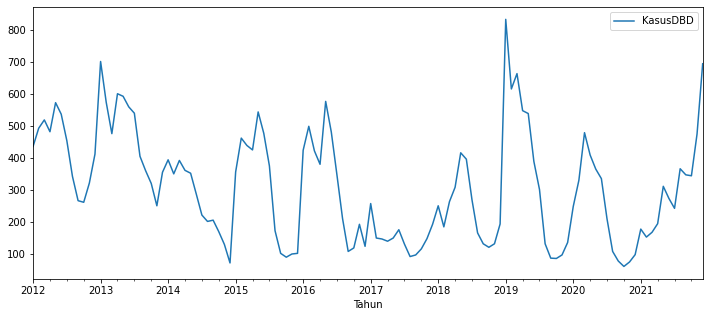

In [126]:
ylabel= ' '
xlabel= 'Tahun'
ax = dataTA['KasusDBD'].plot(figsize=(12,5),legend=True)
ax.autoscale(axis='x',tight=True)

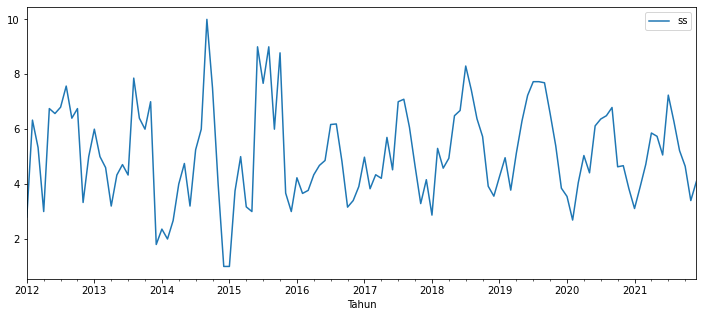

In [127]:
ylabel= ' '
xlabel= 'Tahun'
ax = dataTA['ss'].plot(figsize=(12,5),legend=True)
ax.autoscale(axis='x',tight=True)

UJI STASIONER

In [128]:
data=dataTA[['KasusDBD', 'ss']]
data.columns = ['KasusDBD', 'ss']
data.shape

(120, 2)

In [129]:
for name, column in data.iteritems():
    Augmented_Dickey_Fuller_Test_func(data[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: KasusDBD
Test Statistic                  -4.822679
p-value                          0.000049
No Lags Used                     4.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: ss
Test Statistic                  -2.548885
p-value                          0.104029
No Lags Used                    13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary




UJI KORELASI

In [130]:
data.corr()

,KasusDBD,ss
KasusDBD,1.000000,-0.117148
ss,-0.117148,1.000000


NORMALISASI DATA

In [131]:
max_kasus = data['KasusDBD'].max()
max_ss = data['ss'].max()


In [132]:
data['KasusDBD'] = data['KasusDBD']/max_kasus
data['ss'] = data['ss']/max_ss
data

C:\Users\asus\AppData\Local\Temp\ipykernel_22392\924132680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['KasusDBD'] = data['KasusDBD']/max_kasus
C:\Users\asus\AppData\Local\Temp\ipykernel_22392\924132680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ss'] = data['ss']/max_ss


,KasusDBD,ss
Tahun,,
2012-01-01,0.522782,0.280
2012-02-01,0.591127,0.633
2012-03-01,0.622302,0.533
2012-04-01,0.577938,0.300
2012-05-01,0.687050,0.675
...,...,...
2021-08-01,0.438849,0.628
2021-09-01,0.416067,0.522
2021-10-01,0.412470,0.465


UJI STASIONER

In [133]:
for name, column in data.iteritems():
    Augmented_Dickey_Fuller_Test_func(data[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: KasusDBD
Test Statistic                  -4.822679
p-value                          0.000049
No Lags Used                     4.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: ss
Test Statistic                  -2.548885
p-value                          0.104029
No Lags Used                    13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary




TRAIN TEST SPLIT

In [134]:
n = 12
train,test = data[0:-n], data[-n:]
train_diff=train.diff(periods=2)
train_diff.dropna(inplace=True)
train_diff

,KasusDBD,ss
Tahun,,
2012-03-01,0.099520,0.253
2012-04-01,-0.013189,-0.333
2012-05-01,0.064748,0.142
2012-06-01,0.065947,0.357
2012-07-01,-0.142686,0.005
...,...,...
2020-08-01,-0.273381,0.037
2020-09-01,-0.158273,0.042
2020-10-01,-0.056355,-0.186


In [135]:
for name, column in train_diff.iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: KasusDBD
Test Statistic                 -4.068109
p-value                         0.001093
No Lags Used                   10.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: ss
Test Statistic                -7.197677e+00
p-value                        2.410747e-10
No Lags Used                   9.000000e+00
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary




In [136]:
cointegration_test(train_diff[['KasusDBD', 'ss']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
KasusDBD >  88.54     > 12.3212   =>   True
ss     >  38.99     > 4.1296    =>   True


Text(0.5, 1.0, 'Partial Autocorrelation Function KasusDBD')

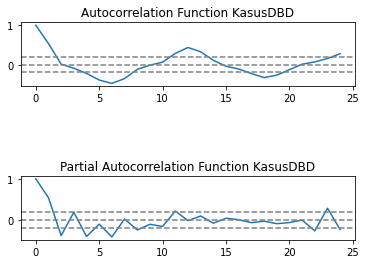

In [137]:
#KASUS DBD
kasusDBD_acf = acf(train_diff['KasusDBD'], nlags=24)
kasusDBD_pacf = pacf(train_diff['KasusDBD'], nlags=24, method='ols')

#Plot ACF: 
plt.subplot(311) 
plt.plot(kasusDBD_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff['KasusDBD'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff['KasusDBD'])),linestyle='--',color='gray')
plt.title(f'Autocorrelation Function KasusDBD')

#Plot PACF:
plt.subplot(313)
plt.plot(kasusDBD_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff['KasusDBD'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff['KasusDBD'])),linestyle='--',color='gray')
plt.title(f'Partial Autocorrelation Function KasusDBD')

Text(0.5, 1.0, 'Partial Autocorrelation Function SS')

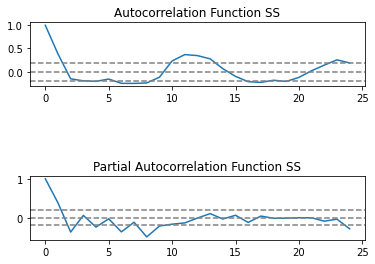

In [138]:
#SS
rhavg_acf = acf(train_diff['ss'], nlags=24)
rhavg_pacf = pacf(train_diff['ss'], nlags=24, method='ols')

#Plot ACF: 
plt.subplot(311) 
plt.plot(rhavg_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff['ss'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff['ss'])),linestyle='--',color='gray')
plt.title(f'Autocorrelation Function SS')

#Plot PACF:
plt.subplot(313)
plt.plot(rhavg_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff['ss'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff['ss'])),linestyle='--',color='gray')
plt.title(f'Partial Autocorrelation Function SS')

AUTO ARIMA

In [139]:
pq = []
for name, column in train_diff[['KasusDBD', 'ss']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : KasusDBD
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-43.288, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-77.365, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-92.209, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-93.825, Time=0.11 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-110.516, Time=0.16 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-109.662, Time=0.18 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-108.688, Time=0.20 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0]          
Total fit time: 2.353 seconds
optimal order for:KasusDBD is: (4, 0, 0) 


Searching order of p and q for 

VARMA MODEL ORDER SELECTION

In [140]:
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        model = VARMAX(train_diff, order=(i[0],i[2]))
        result=model.fit( disp=False)
        print(f'VARMA Order {i}')
        print('AIC {}'.format(result.aic))
        print('BIC {}'.format(result.bic))
        print()

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMA Order (4, 0, 0)
AIC -193.52966209775747
BIC -137.59744112140407

VARMA Order (2, 0, 0)
AIC -165.78153834839543
BIC -131.15683012493855



In [141]:
varma_model = VARMAX(train_diff[['KasusDBD','ss']], order=(4,0),enforce_stationarity= True)
fitted_model = varma_model.fit(disp=False)
print(fitted_model.summary())

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Statespace Model Results                           
Dep. Variable:     ['KasusDBD', 'ss']   No. Observations:                  106
Model:                         VAR(4)   Log Likelihood                 117.765
                          + intercept   AIC                           -193.530
Date:                Thu, 18 Aug 2022   BIC                           -137.597
Time:                        18:13:04   HQIC                          -170.860
Sample:                    03-01-2012                                         
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.02, 0.12   Jarque-Bera (JB):         344.95, 0.96
Prob(Q):                        0.90, 0.73   Prob(JB):                   0.00, 0.62
Heteroskedasticity (H):         1.88, 0.29   Skew:                       1.60, 0.19
Prob(H) (two-sided):            0.07,

PREDIKSI KASUS DBD

In [142]:
m = len(train_diff)
predict = fitted_model.get_prediction(start=m,end=m+n-1)
prediction=predict.predicted_mean
prediction

,KasusDBD,ss
2021-01-01,0.121807,-0.018993
2021-02-01,0.108540,0.037674
2021-03-01,0.031418,0.068859
2021-04-01,-0.023487,0.045084
2021-05-01,-0.050380,0.038249
2021-06-01,-0.063241,0.032034
2021-07-01,-0.058393,-0.004273
2021-08-01,-0.034364,-0.031354
2021-09-01,-0.004254,-0.033658
2021-10-01,0.016185,-0.028287


In [143]:
inv_predict = inverse_diff(data,prediction)
inv_predict

,KasusDBD,ss,inv_KasusDBD,inv_ss
2021-01-01,0.121807,-0.018993,0.955140,0.391007
2021-02-01,0.108540,0.037674,1.063680,0.428681
2021-03-01,0.031418,0.068859,1.095098,0.497540
2021-04-01,-0.023487,0.045084,1.071611,0.542624
2021-05-01,-0.050380,0.038249,1.021231,0.580874
2021-06-01,-0.063241,0.032034,0.957990,0.612908
2021-07-01,-0.058393,-0.004273,0.899596,0.608635
2021-08-01,-0.034364,-0.031354,0.865232,0.577281
2021-09-01,-0.004254,-0.033658,0.860978,0.543623
2021-10-01,0.016185,-0.028287,0.877163,0.515336


In [144]:
test_vs_prediction = pd.concat([test,inv_predict[['inv_KasusDBD','inv_ss']]],axis=1)
test_vs_prediction

,KasusDBD,ss,inv_KasusDBD,inv_ss
2021-01-01,0.212230,0.311,0.955140,0.391007
2021-02-01,0.182254,0.390,1.063680,0.428681
2021-03-01,0.200240,0.472,1.095098,0.497540
2021-04-01,0.232614,0.586,1.071611,0.542624
2021-05-01,0.372902,0.574,1.021231,0.580874
2021-06-01,0.327338,0.506,0.957990,0.612908
2021-07-01,0.290168,0.724,0.899596,0.608635
2021-08-01,0.438849,0.628,0.865232,0.577281
2021-09-01,0.416067,0.522,0.860978,0.543623
2021-10-01,0.412470,0.465,0.877163,0.515336


MENGEMBALIKAN NILAI ASLI

In [145]:
test_vs_prediction['inv_KasusDBD'] = test_vs_prediction['inv_KasusDBD']*max_kasus
test_vs_prediction['inv_ss'] = test_vs_prediction['inv_ss']*max_ss
test_vs_prediction['KasusDBD'] = test_vs_prediction['KasusDBD']*dataTA['KasusDBD'].max()
test_vs_prediction['ss'] = test_vs_prediction['ss']*dataTA['ss'].max()
test_vs_prediction

,KasusDBD,ss,inv_KasusDBD,inv_ss
2021-01-01,177.0,3.11,796.586882,3.910069
2021-02-01,152.0,3.90,887.109523,4.286808
2021-03-01,167.0,4.72,913.312059,4.975402
2021-04-01,194.0,5.86,893.723603,5.426243
2021-05-01,311.0,5.74,851.706675,5.808737
2021-06-01,273.0,5.06,798.963297,6.129078
2021-07-01,242.0,7.24,750.263315,6.086346
2021-08-01,366.0,6.28,721.603350,5.772806
2021-09-01,347.0,5.22,718.055543,5.436229
2021-10-01,344.0,4.65,731.553565,5.153362


CONVERTING PREDICTION FROM FLOAT TO INTEGER

In [146]:
# converting 'test_vs_prediction' from float to int
test_vs_prediction[['inv_KasusDBD']] = test_vs_prediction[['inv_KasusDBD']].apply(np.int64)

# displaying the datatypes
display(test_vs_prediction.dtypes)
test_vs_prediction

KasusDBD        float64
ss              float64
inv_KasusDBD      int64
inv_ss          float64
dtype: object

,KasusDBD,ss,inv_KasusDBD,inv_ss
2021-01-01,177.0,3.11,796,3.910069
2021-02-01,152.0,3.90,887,4.286808
2021-03-01,167.0,4.72,913,4.975402
2021-04-01,194.0,5.86,893,5.426243
2021-05-01,311.0,5.74,851,5.808737
2021-06-01,273.0,5.06,798,6.129078
2021-07-01,242.0,7.24,750,6.086346
2021-08-01,366.0,6.28,721,5.772806
2021-09-01,347.0,5.22,718,5.436229
2021-10-01,344.0,4.65,731,5.153362


In [147]:
for i in ['KasusDBD','ss']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test_vs_prediction[str(i)],test_vs_prediction['inv_'+str(i)])

Evaluation metric for KasusDBD
Evaluation metric results:-
MSE is : 274098.25
MAE is : 486.4166666666667
RMSE is : 523.5439332090479
MAPE is : 2.1679966467189304

Evaluation metric for ss
Evaluation metric results:-
MSE is : 0.6095633707093563
MAE is : 0.6530810802902377
RMSE is : 0.7807453942927594
MAPE is : 0.14771240037033515



<AxesSubplot:>

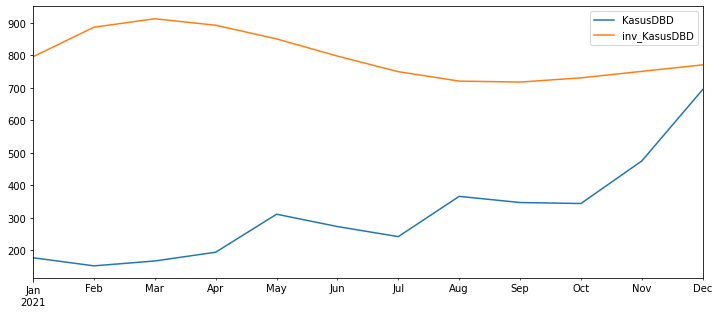

In [148]:
test_vs_prediction[['KasusDBD','inv_KasusDBD']].plot(figsize=(12,5))

<AxesSubplot:>

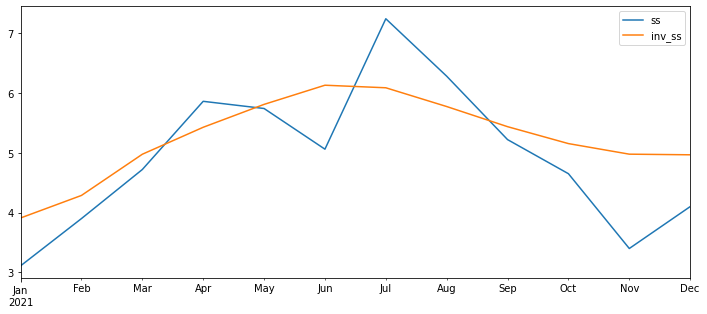

In [149]:
test_vs_prediction[['ss','inv_ss']].plot(figsize=(12,5))

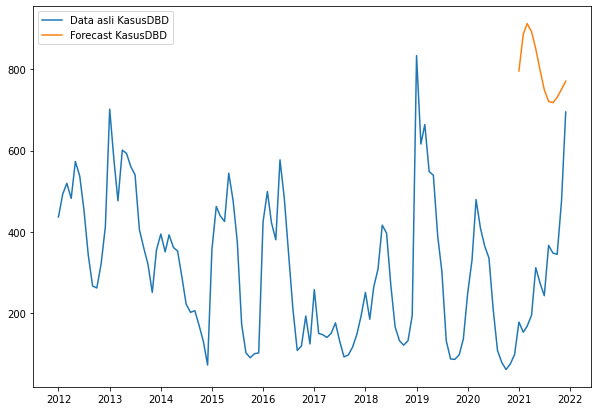

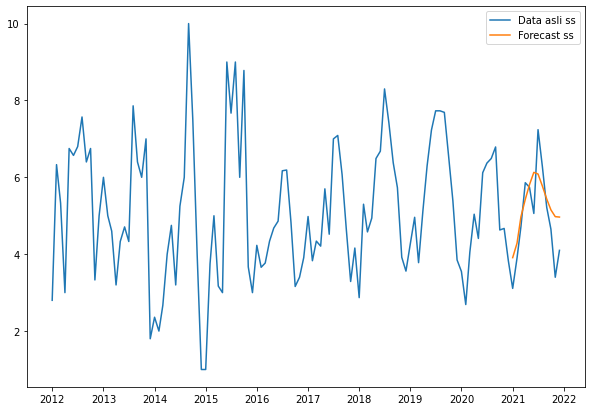

In [150]:
for i in ['KasusDBD','ss']:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(dataTA[str(i)], label='Data asli '+str(i))
    plt.plot(test_vs_prediction['inv_'+str(i)], label='Forecast '+str(i))
    plt.legend(loc='best')
    plt.show()